<a href="https://colab.research.google.com/github/trandangtrungduc/BasicDeepLearningTask/blob/main/Fruit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# **1. Preparing and exploring the data**






> Connect Google Drive to Google Colab and import necessary librabries



In [ ]:
from google.colab import drive # Mount drive to google colab
drive.mount('/content/drive')

Mounted at /content/drive


> Import necessary librabries

In [ ]:
# Library for algebra, image processing, dataframe, preprocessing, visualization
import os
import cv2
import glob
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Library for Deep learning
import keras 
import tensorflow as tf
from keras.models import Model
from keras.optimizers import SGD, Adamax, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, CuDNNLSTM
# Backend
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

> Show some samples

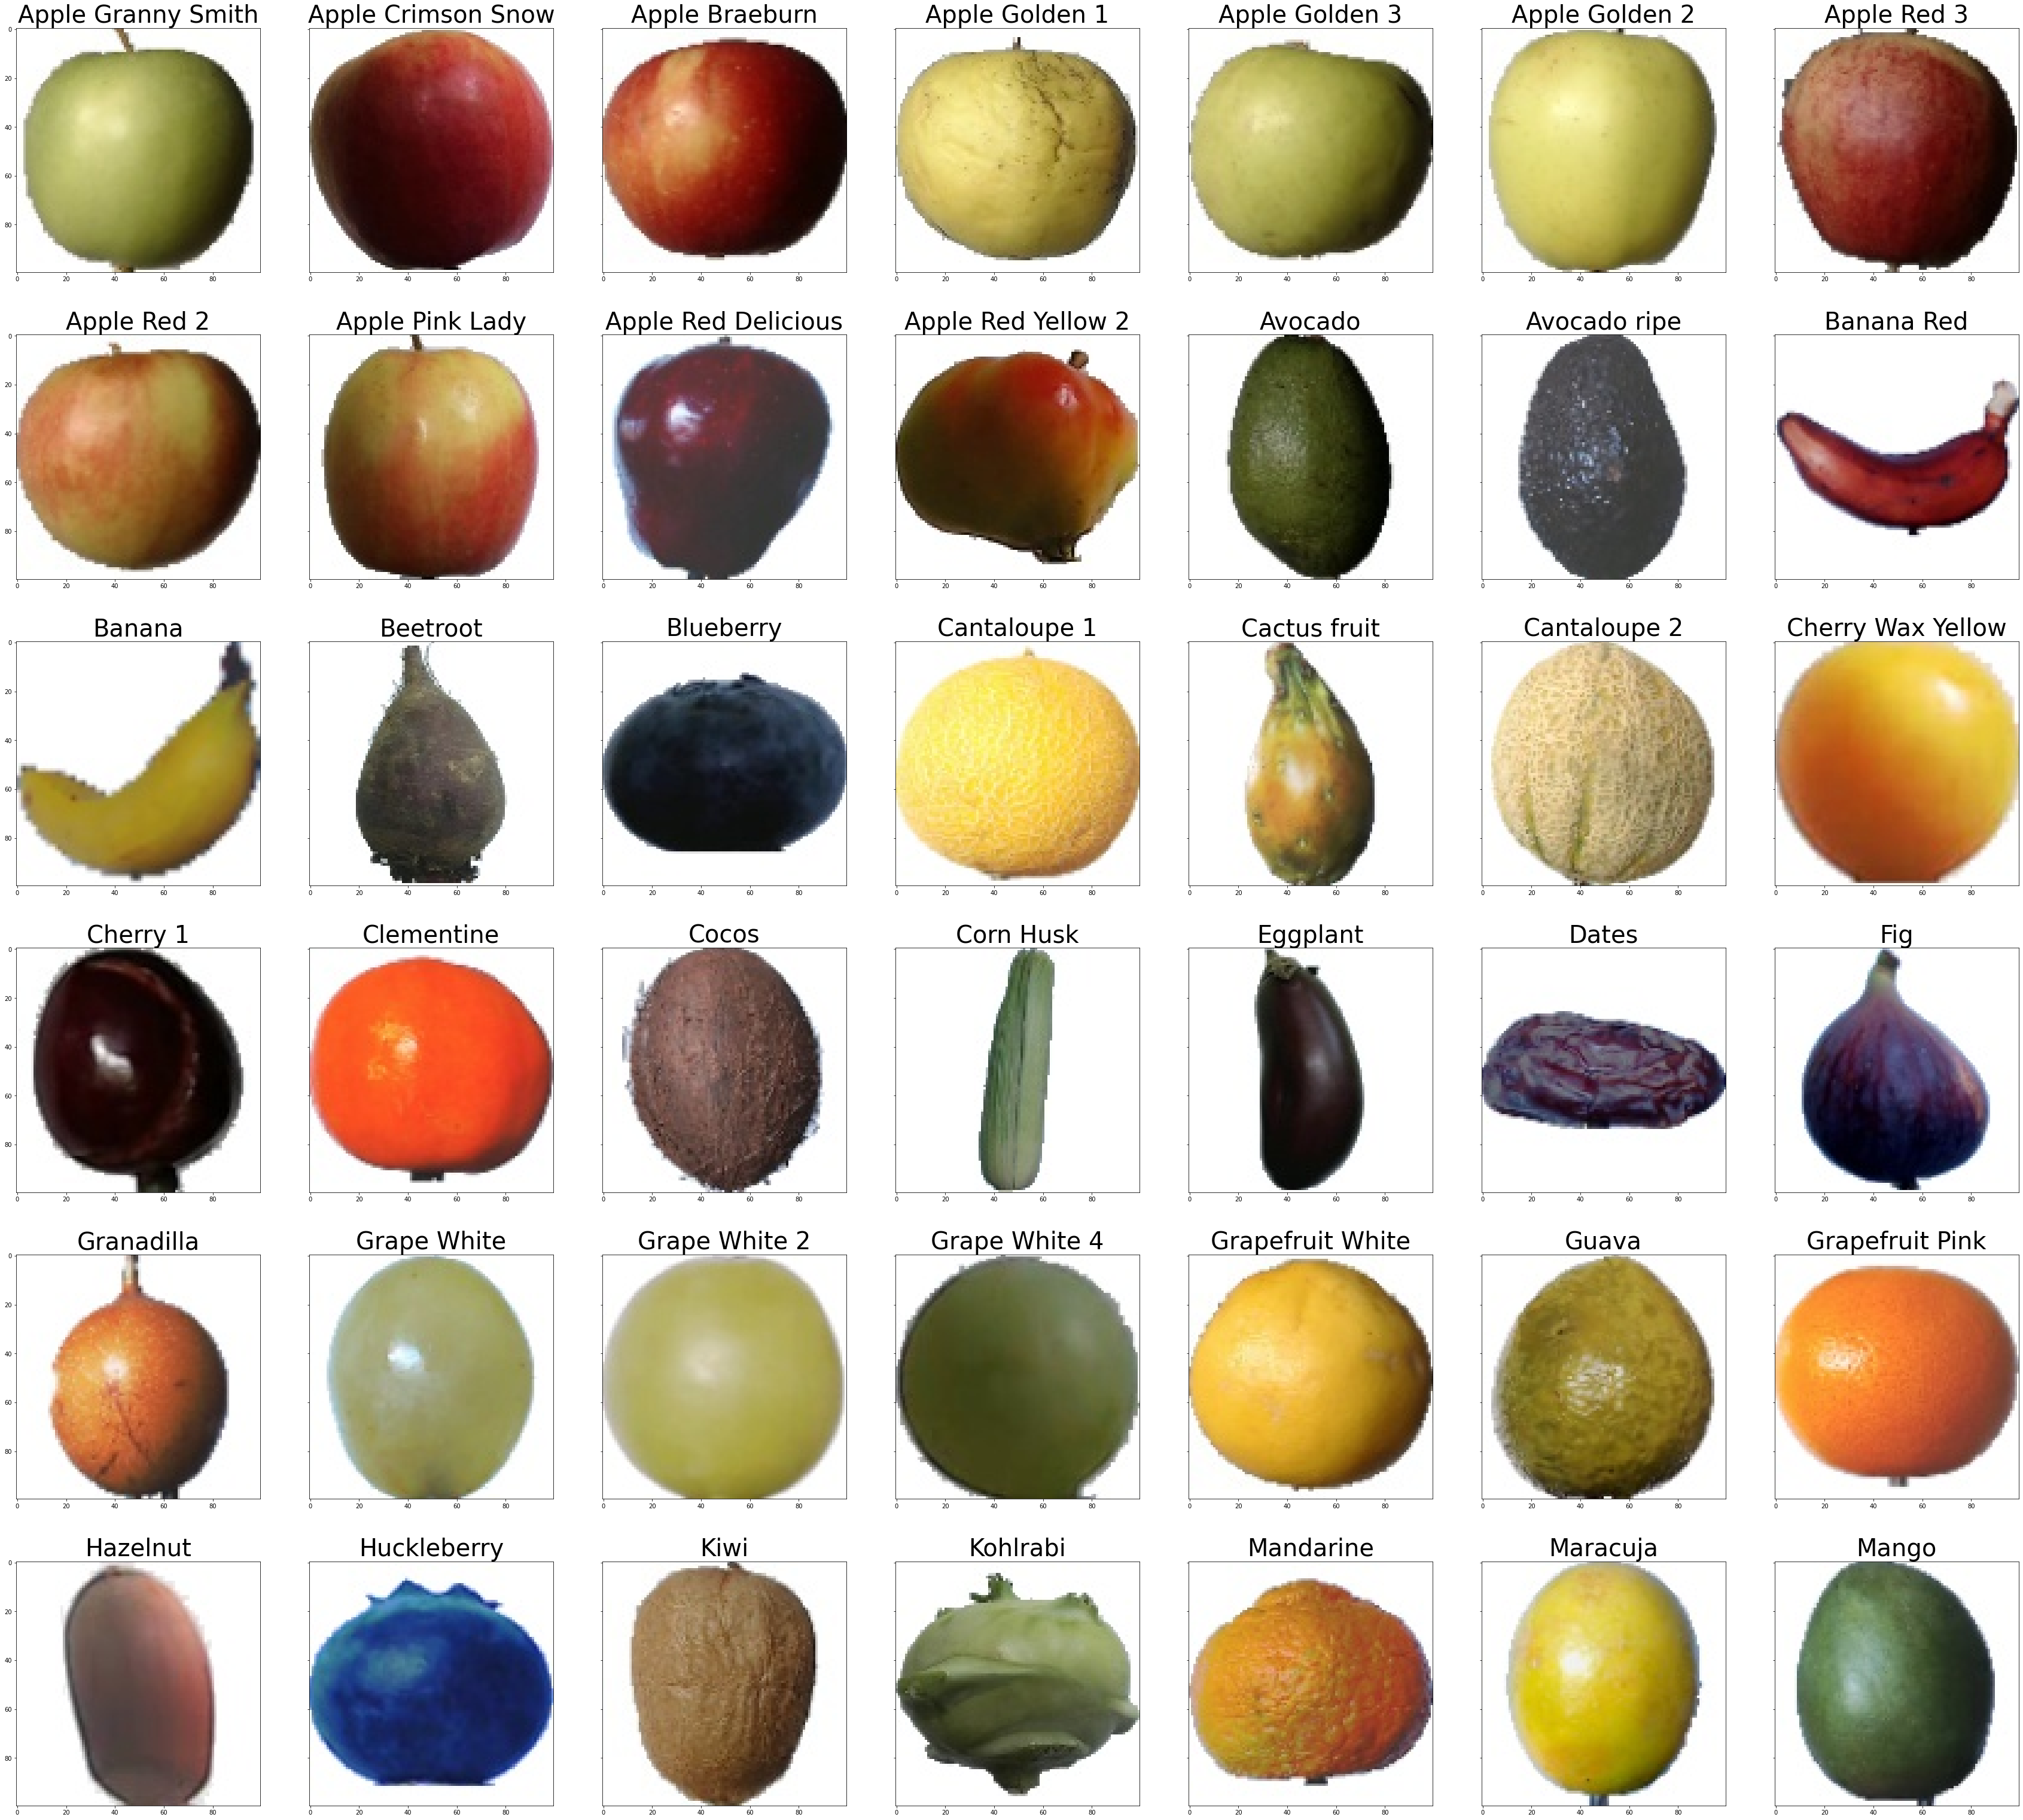

In [ ]:
fig, axs = plt.subplots(6,7, figsize=(60, 55), sharey='row') # Create new figure to visualize some images
i=0 # Count variable
axs = axs.ravel()
for fruit_dir_path in glob.glob("/content/drive/MyDrive/Data/fruits-360/Training/*"): # Folder in directory path
    image = cv2.imread(fruit_dir_path + "/0_100.jpg",cv2.IMREAD_COLOR) # Read RBG image
    image = cv2.resize(image,(100,100)) # Resize image
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # Convert RGB to BGR 
    axs[i].set_title(str(fruit_dir_path.split("/")[7]),fontsize=40)
    axs[i].imshow(image) # Show image    
    i+=1 # Increment
plt.show() # Show all

# **2. CNN Model**

> Define constant and initialize data using Generator

In [ ]:
# Define size of image, batch size and epochs
img_height, img_width, channels = 100, 100, 3
batch_size, epochs = 128, 10

In [ ]:
# Configure train data and test data using generator
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.2)  
test_datagen = ImageDataGenerator(rescale=1./255)                                                                                                                                                                                                                                          

In [ ]:
# ImageGenerator for train, test and validation set
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Data/fruit_classification/fruits-360/Training',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset="training")
validation_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Data/fruit_classification/fruits-360/Training',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset="validation")
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Data/fruit_classification/fruits-360/Test',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22698 images belonging to 131 classes.


> Train model with CNN

In [ ]:
# Define some constants
train_per_epoch = train_generator.samples//batch_size
validation_steps = validation_generator.samples//batch_size
test_steps = test_generator.samples//batch_size

In [ ]:
# Architecture
model = keras.Sequential()
# Define CNN model with Convolution layer, Dropout layer, Fully Connect layer and MaxPooling layer
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(img_height,img_width,channels)))  
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(131, activation='softmax'))
# Compile
model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0

In [ ]:
# Callbacks during train
my_callbacks = [EarlyStopping(patience=2,
                              monitor="val_loss",),               
                ModelCheckpoint(filepath='/content/drive/MyDrive/Data/fruit_classification/fruits-360/Model_weights/model.{epoch:02d}-{loss:.2f}.h5',
                                monitor='val_loss',
                                save_best_only=True),
                TensorBoard(log_dir='/content/drive/MyDrive/Data/fruits-360/Model_weights/logs')]


In [ ]:
# Train model
H = model.fit_generator(train_generator,
                        steps_per_epoch=train_per_epoch,
                        epochs=epochs,
                        verbose=1,
                        validation_data=validation_generator,
                        validation_steps=validation_steps,
                        callbacks=my_callbacks)

Epoch 1/10
113/423 [=======>......................] - ETA: 4:41:12 - loss: 4.5534 - accuracy: 0.0368

> Evaluate and visualize

In [ ]:
# Load model
model.load_weights('/content/drive/MyDrive/Data/fruit_classification/fruits-360/Model_weights/model.05-0.08.h5')

In [ ]:
# Score with test set
scores = model.evaluate_generator(generator=test_generator, steps=test_steps)
print('Accuracy: %.2f' % (scores[1]*100))

Accuracy: 95.99


In [ ]:
# Label of data
Label_name = list(test_generator.class_indices.keys())
print(Label_name)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [ ]:
# Create array contains label name
true_array = np.array([]) # Create empty array
predict_array = np.array([]) # Create empty array
for i in range(test_steps): 
  X_test, y_test = next(test_generator) # Split test_generator to  train and test
  predicted = model.predict(X_test, batch_size=128)  # Predict with X_test
  y_true = np.argmax(y_test, axis=1) # Choose the label with the highest probability
  y_pred = np.argmax(predicted, axis=1) # Choose the label with the highest probability
  true_array = np.append(true_array, y_true) # Add to array
  predict_array = np.append(predict_array, y_pred) # Add to array

In [ ]:
report = classification_report(y_true=true_array, y_pred=predict_array, target_names=Label_name) # Calculate precision, recall, f1-score
print(report) # Show report

                     precision    recall  f1-score   support

     Apple Braeburn       0.85      0.74      0.79       165
 Apple Crimson Snow       1.00      0.93      0.96       146
     Apple Golden 1       0.86      0.87      0.86       160
     Apple Golden 2       0.92      1.00      0.96       163
     Apple Golden 3       1.00      0.98      0.99       162
 Apple Granny Smith       0.98      1.00      0.99       166
    Apple Pink Lady       0.88      1.00      0.93       150
        Apple Red 1       0.87      1.00      0.93       165
        Apple Red 2       0.84      0.95      0.89       165
        Apple Red 3       0.94      1.00      0.97       144
Apple Red Delicious       1.00      1.00      1.00       165
 Apple Red Yellow 1       1.00      0.81      0.90       162
 Apple Red Yellow 2       1.00      1.00      1.00       216
            Apricot       1.00      1.00      1.00       163
            Avocado       0.99      1.00      0.99       144
       Avocado ripe    

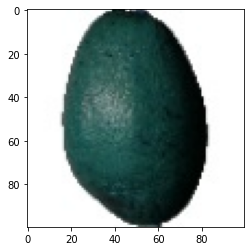

In [ ]:
img_single = cv2.imread("/content/drive/MyDrive/Data/fruit_classification/fruits-360/Training/Avocado/0_100.jpg") # Read single image
img_single_resized = cv2.resize(img_single, (100,100), interpolation = cv2.INTER_AREA) # Resize image
plt.imshow(img_single_resized) # Show image

In [ ]:
 def get_layers_to_predict(img_single_resized, layer): 
  img_single_resized = np.reshape(img_single_resized, (1,) + img_single_resized.shape) # Reshape to (batch_size, width, height, channels) 
  subModel = Model(model.input, model.layers[layer].output) # Get desired layer in model
  predictions_subModel = subModel.predict(img_single_resized) # Predict with selected layer                                                                                  
  return predictions_subModel

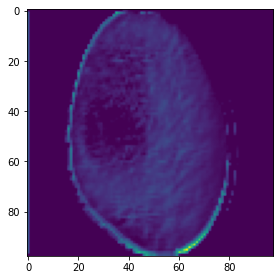

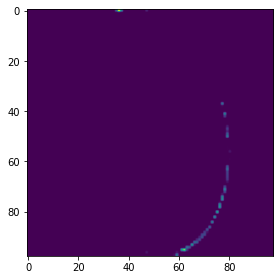

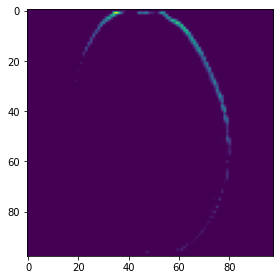

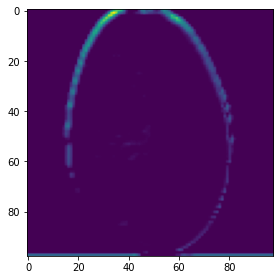

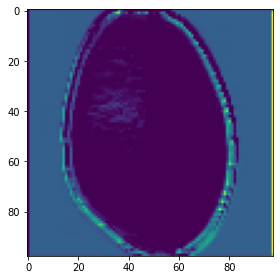

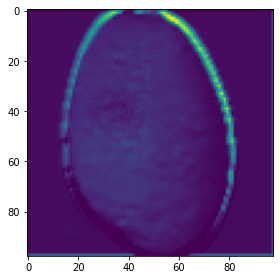

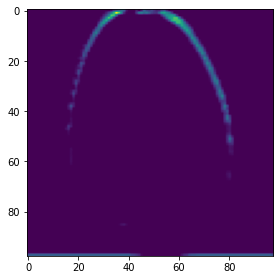

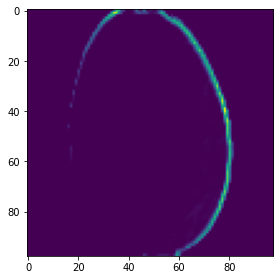

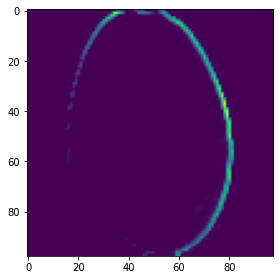

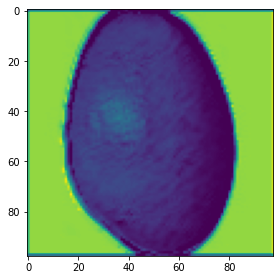

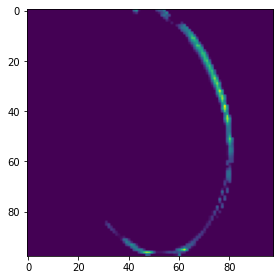

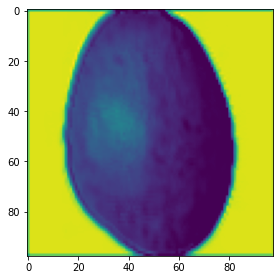

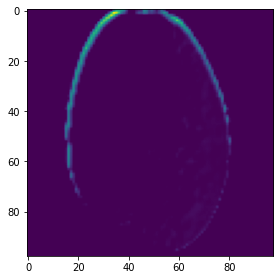

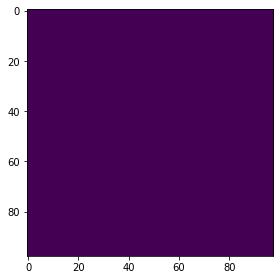

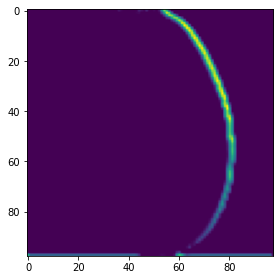

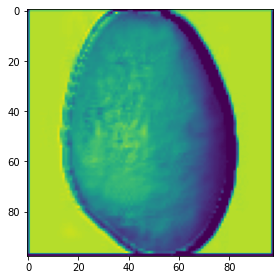

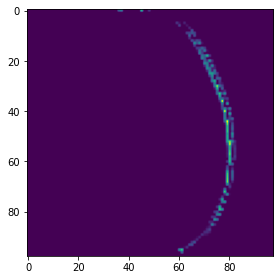

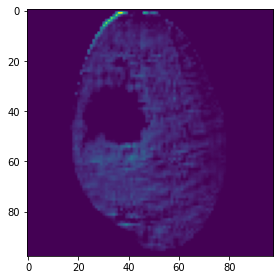

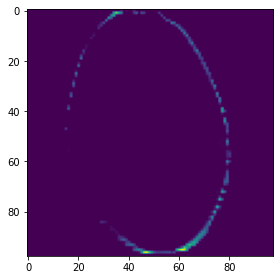

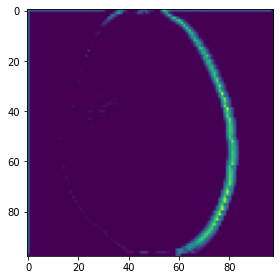

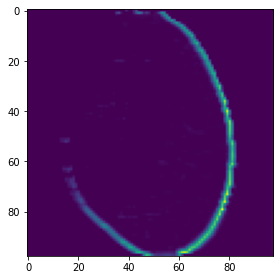

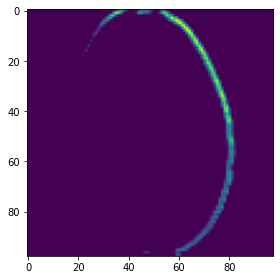

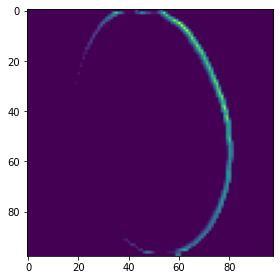

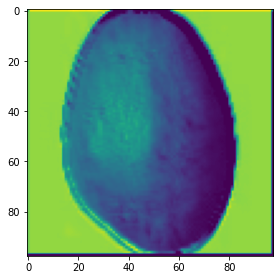

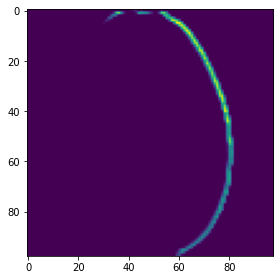

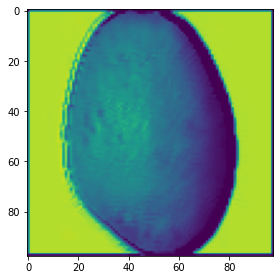

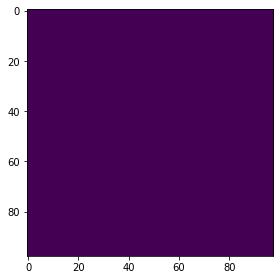

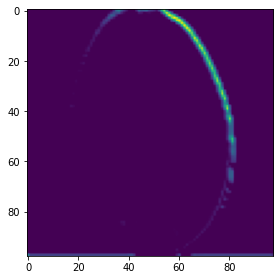

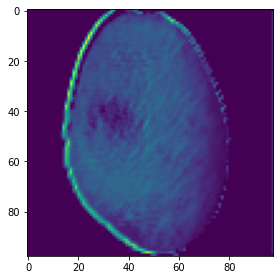

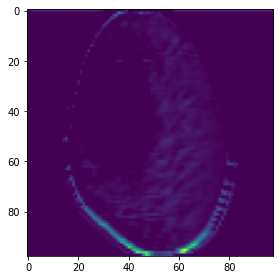

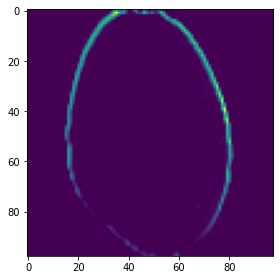

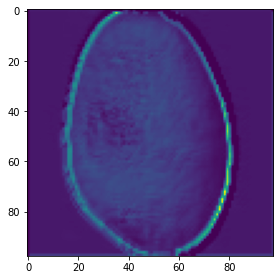

In [ ]:
Avocado_layer_1 = get_layers_to_predict(img_single_resized,1) # Get layer 1 in model
Avocado_layer_2 = get_layers_to_predict(img_single_resized,2) # Get layer 2 in model

def visualize_layer(predict_subModel):  
  for i in range(32):
    plt.imshow(predict_subModel[0,:,:,i]) # Show image after each filter
    plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area
    plt.show() # Plot all

visualize_layer(Avocado_layer_1) # Plot image

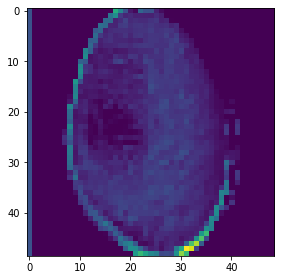

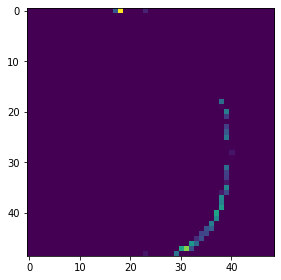

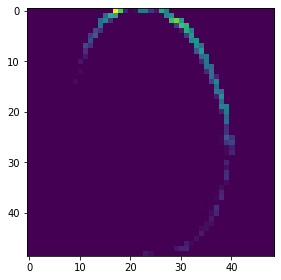

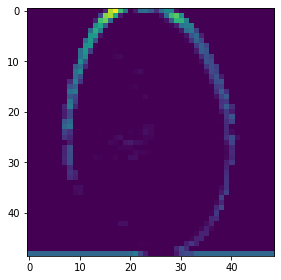

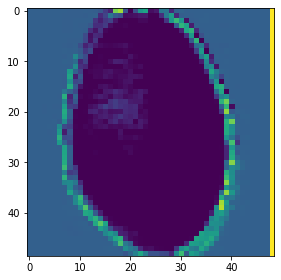

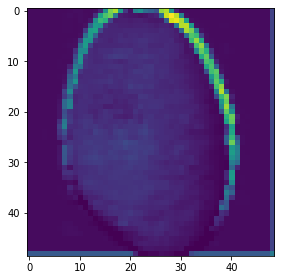

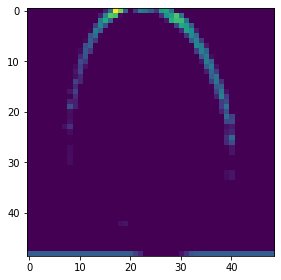

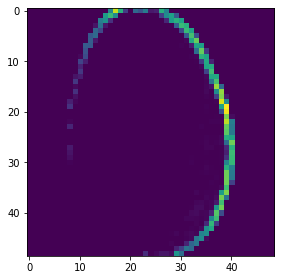

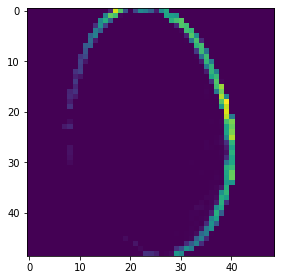

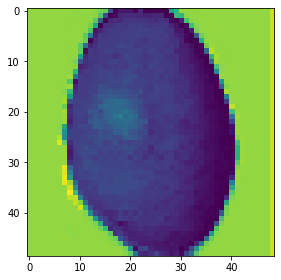

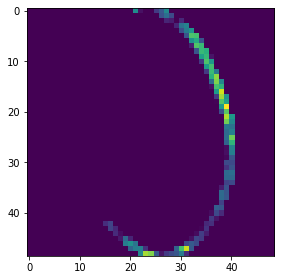

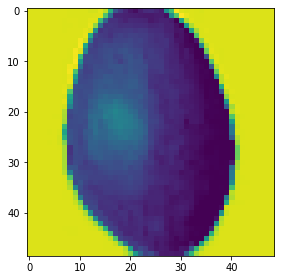

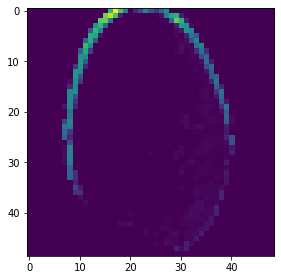

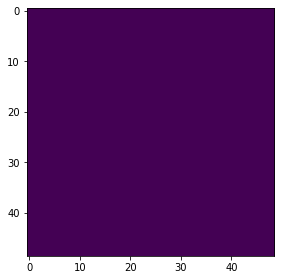

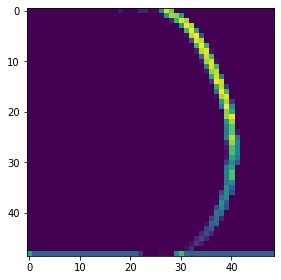

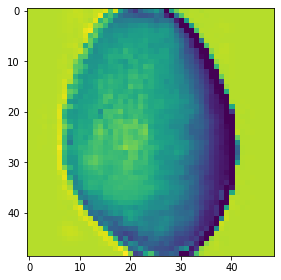

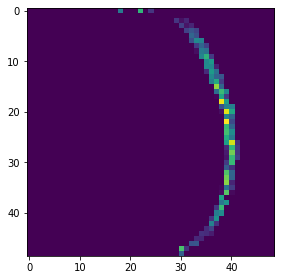

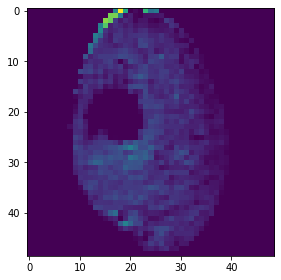

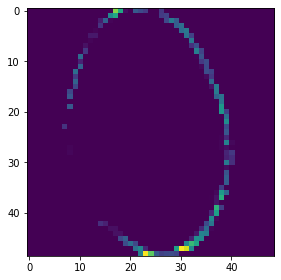

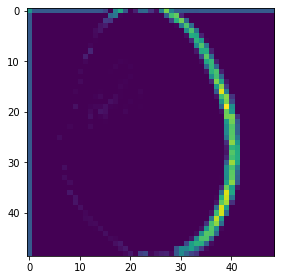

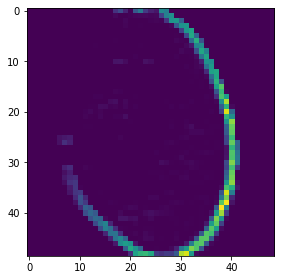

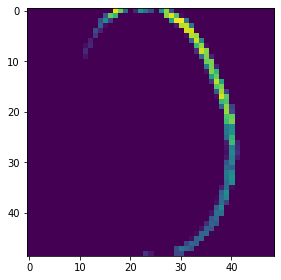

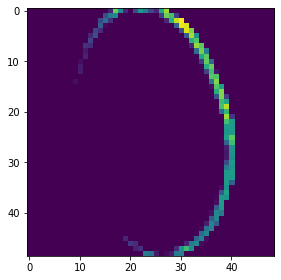

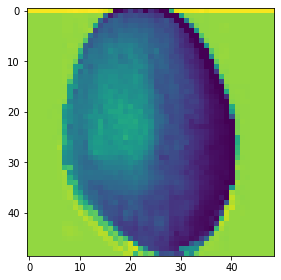

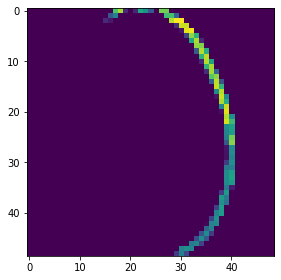

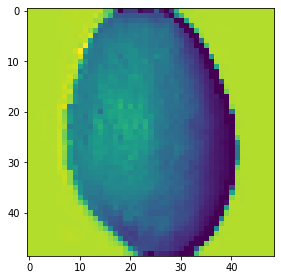

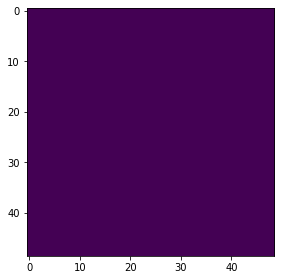

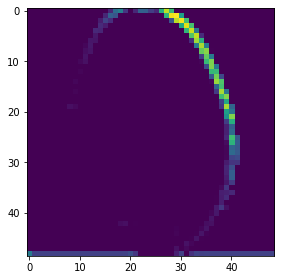

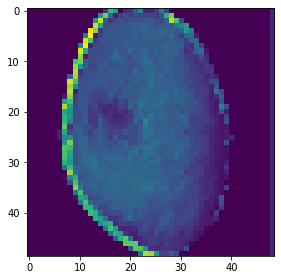

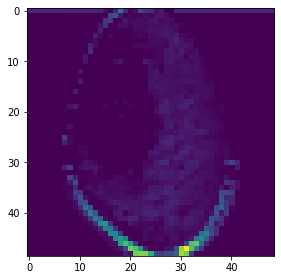

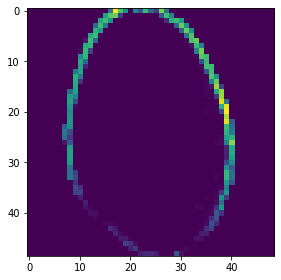

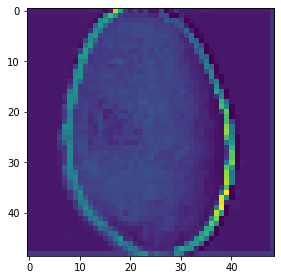

In [ ]:
visualize_layer(Avocado_layer_2)

In [ ]:
!tensorboard --logdir /content/drive/MyDrive/Data/fruit_classification/fruits-360/Model_weights/logs 

In [ ]:
# Function support visualize
def Visualization_results(evaluate_para_train, evaluate_para_validation):
  sns.set_theme(style="darkgrid", palette="deep") # Set theme for graph
  plt.figure(figsize=(15,10)) # Create new figure
  sns.lineplot(range(0, len(H.history[evaluate_para_train])), H.history[evaluate_para_train], marker='o', color='green') # Draw line
  sns.lineplot(range(0, len(H.history[evaluate_para_validation])), H.history[evaluate_para_validation], marker='o', color='orange') # Draw line
  plt.title('Result evaluation graph') # Set title for figure
  plt.xlabel('Epochs') # Set label for x axis
  plt.ylabel(evaluate_para_train) # Set label for y 
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show() # Plot all

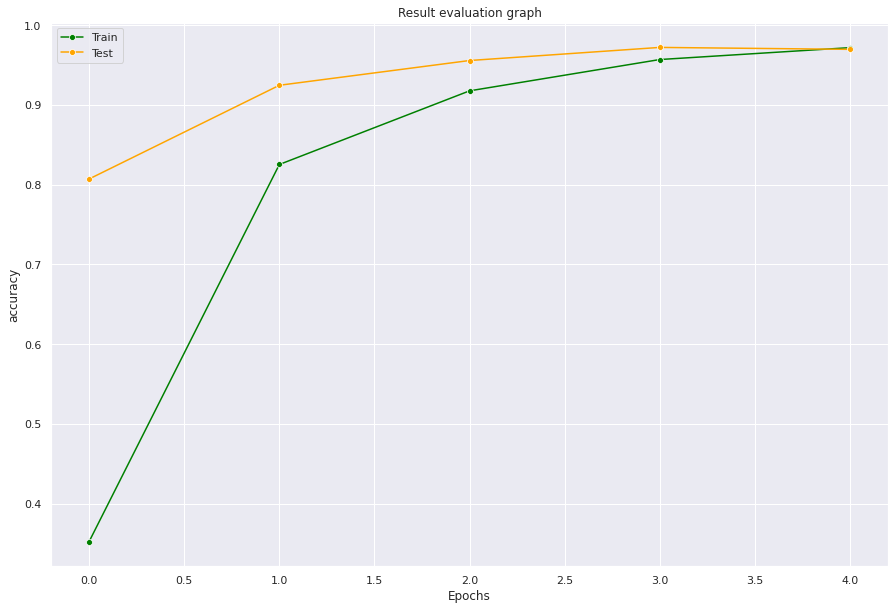

In [ ]:
Visualization_results('accuracy','val_accuracy') # Visualize accuracy and validation_accuracy

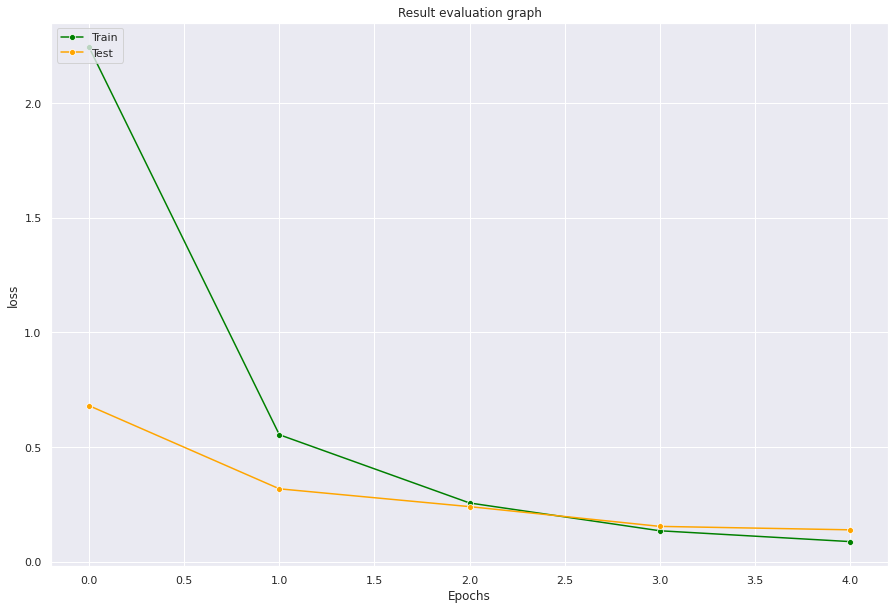

In [ ]:
Visualization_results('loss','val_loss')# Visualize loss and validation_loss

# **3. RNN Model**

In [ ]:
# Configure train data and test data using generator
train_datagen_LSTM = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True, validation_split=0.2)  
test_datagen_LSTM = ImageDataGenerator(rescale=1./255)
# Found 54190 images belonging to 131 classes.
# Found 13502 images belonging to 131 classes.
# Found 22698 images belonging to 131 classes.

In [ ]:
# ImageGenerator for train, test and validation set
train_generator_LSTM = train_datagen_LSTM.flow_from_directory('/content/drive/MyDrive/Data/fruits-360/Training',
                                                    target_size=(img_height, img_width),
                                                    batch_size=6574,
                                                    class_mode='sparse',
                                                    subset="training")
validation_generator_LSTM = train_datagen_LSTM.flow_from_directory('/content/drive/MyDrive/Data/fruits-360/Training',
                                                    target_size=(img_height, img_width),
                                                    batch_size=1643,
                                                    class_mode='sparse',
                                                    subset="validation")
test_generator_LSTM = test_datagen_LSTM.flow_from_directory('/content/drive/MyDrive/Data/fruits-360/Test',
                                                    target_size=(img_height, img_width),
                                                    batch_size=2100,
                                                    class_mode='sparse')

Found 6574 images belonging to 42 classes.
Found 1643 images belonging to 42 classes.
Found 2100 images belonging to 42 classes.


In [ ]:
X_train, y_train = train_generator_LSTM.next()
X_valid, y_valid = validation_generator_LSTM.next()
X_test, y_test = test_generator_LSTM.next()

In [ ]:
X_train = X_train.reshape(6574,img_height*img_width,channels)/255.0
X_valid = X_valid.reshape(1643,img_height*img_width,channels)/255.0
X_test = X_test.reshape(2100,img_height*img_width,channels)/255.0

In [ ]:
X_train.shape

(6574, 100, 100, 3)

In [ ]:
# Callbacks during train
my_callbacks_LSTM = [EarlyStopping(patience=2,
                              monitor="val_loss",),               
                ModelCheckpoint(filepath='/content/drive/MyDrive/Data/fruits-360/Model_weights/model.{epoch:02d}-{loss:.2f}.h5',
                                monitor='val_loss',
                                save_best_only=True),
                TensorBoard(log_dir='/content/drive/MyDrive/Data/fruits-360/Model_weights/logs')]

In [ ]:
model_LSTM = keras.Sequential()
# Define LSTM model 
model_LSTM.add(CuDNNLSTM(128, input_shape = (X_train.shape[1:]), return_sequences=True))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(CuDNNLSTM(256))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(Dense(512, activation='relu'))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(Dense(42,activation='softmax'))
# Compile
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_56 (CuDNNLSTM)    (None, 10000, 128)        68096     
_________________________________________________________________
dropout_106 (Dropout)        (None, 10000, 128)        0         
_________________________________________________________________
cu_dnnlstm_57 (CuDNNLSTM)    (None, 256)               395264    
_________________________________________________________________
dropout_107 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_108 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 42)              

In [ ]:
# Train model
H_LSTM = model_LSTM.fit(X_train,y_train,epochs=epochs,verbose=1,validation_data=(X_valid,y_valid),callbacks=my_callbacks_LSTM)                      

Epoch 1/10
206/206 [==============================] - 221s 956ms/step - loss: 3.7361 - accuracy: 0.0274 - val_loss: 3.7236 - val_accuracy: 0.0243
Epoch 2/10
206/206 [==============================] - 188s 913ms/step - loss: 3.7289 - accuracy: 0.0239 - val_loss: 3.7223 - val_accuracy: 0.0243
Epoch 3/10
206/206 [==============================] - 188s 911ms/step - loss: 3.7239 - accuracy: 0.0263 - val_loss: 3.7227 - val_accuracy: 0.0243
Epoch 4/10
206/206 [==============================] - 187s 910ms/step - loss: 3.7256 - accuracy: 0.0225 - val_loss: 3.7239 - val_accuracy: 0.0243


> **Because the model gives very bad results, this model will not be used for fruit classification**

> Test model with Mnist dataset




In [ ]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
print('Shape of train data: ', x_train.shape)
print('Shape of test data: ', y_train.shape)

Shape of train data:  (60000, 28, 28)
Shape of test data:  (60000,)


In [ ]:
model_mnist = keras.Sequential()
# Define LSTM model 
model_mnist.add(CuDNNLSTM(128, input_shape = (x_train.shape[1:]), return_sequences=True))
model_mnist.add(Dropout(0.1))
model_mnist.add(CuDNNLSTM(256))
model_mnist.add(Dropout(0.1))
model_mnist.add(Dense(512, activation='relu'))
model_mnist.add(Dropout(0.1))
model_mnist.add(Dense(42,activation='softmax'))
# Compile
model_mnist.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
model_mnist.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 28, 128)           80896     
_________________________________________________________________
dropout (Dropout)            (None, 28, 128)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               395264    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 42)                2

In [ ]:
# Train model
H_mnist = model_mnist.fit(x_train,y_train,epochs=5,verbose=1,validation_data=(x_test,y_test))                      

Epoch 1/5
1875/1875 [==============================] - 27s 7ms/step - loss: 0.7923 - accuracy: 0.7338 - val_loss: 0.1061 - val_accuracy: 0.9658
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1121 - accuracy: 0.9659 - val_loss: 0.0694 - val_accuracy: 0.9790
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0710 - accuracy: 0.9791 - val_loss: 0.0499 - val_accuracy: 0.9847
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0501 - accuracy: 0.9855 - val_loss: 0.0563 - val_accuracy: 0.9849
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0441 - accuracy: 0.9870 - val_loss: 0.0542 - val_accuracy: 0.9854


> Model gives extremely good result

